In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



In [3]:
df =pd.read_csv("Thyroid_Diff.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

In [5]:
df.describe()

,Age
count,383.000000
mean,40.866841
std,15.134494
min,15.000000
25%,29.000000
50%,37.000000
75%,51.000000
max,82.000000


In [6]:
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


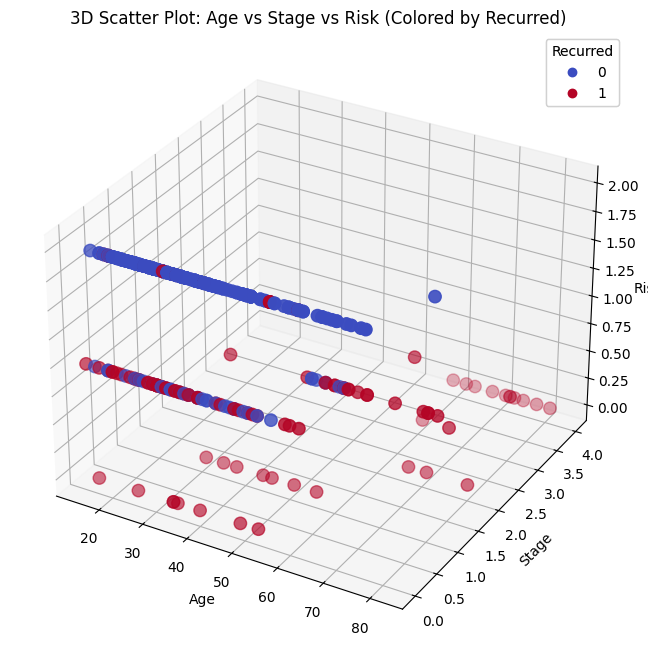

In [7]:
# Encode necessary categorical columns
label_cols = ['Stage', 'Risk', 'Recurred']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Prepare the 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assign axes: Age (X), Stage (Y), Risk (Z)
x = df['Age']
y = df['Stage']
z = df['Risk']
c = df['Recurred']  # Color by recurrence

# Create scatter plot
scatter = ax.scatter(x, y, z, c=c, cmap='coolwarm', s=80)

# Add axis labels
ax.set_xlabel('Age')
ax.set_ylabel('Stage')
ax.set_zlabel('Risk')
ax.set_title('3D Scatter Plot: Age vs Stage vs Risk (Colored by Recurred)')

# Add color legend
legend1 = ax.legend(*scatter.legend_elements(), title="Recurred")
ax.add_artist(legend1)

plt.show()

In [8]:
cat_pipe=Pipeline([("impute",SimpleImputer(strategy="most_frequent")),
                   ("hot_encode",OneHotEncoder(drop="first",handle_unknown="ignore",sparse_output=False))])

In [9]:
num_pipe=Pipeline([("impute",SimpleImputer()),
                   ("scale",StandardScaler())])

In [10]:
class outliers_removing(BaseEstimator,TransformerMixin):
    
    def __init__(self,column=None,method="iqr",startgy="cap"):
        
        self.column=column
        self.method=method
        self.startgy=startgy
            
        
    def fit(self,X,y=None):
        X=pd.DataFrame(X)
        self.bounds={}
        for n in self.column:
            if self.method=="iqr":
                q1=X[n].quantile(0.25)
                q3=X[n].quantile(0.75)
                IQR=q3-q1
                lower_limit=q1-1.5 *IQR
                upper_limit=q3+1.5 * IQR
                self.bounds[n]=(lower_limit,upper_limit)
                
        return self
    def transform(self,X):
        X=X.copy()
        
        for n in self.column:
            lower,upper=self.bounds[n]
            if self.startgy=="cap":
                X[n]=np.where(X[n]>upper,upper,X[n])
                X[n]=np.where(X[n]<lower,lower,X[n])    
        return X

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    int64 
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    int64 
 15  Response              383 non-null    ob

In [12]:
num_col=["Age"]
cat_col=["Gender","Smoking","Hx Smoking","Hx Radiothreapy","Thyroid Function","Physical Examination","Adenopathy","Pathology","Focality","Risk","T","N","M","Stage","Response"]

In [13]:
pre_process=ColumnTransformer([("num_impute_scale",num_pipe,num_col),
                               ("cat_col_encode_imput",cat_pipe,cat_col)
                               ],remainder="passthrough")

In [14]:
train_x,test_x,train_y,test_y=train_test_split(df.drop(["Recurred"],axis=1),df["Recurred"],test_size=0.2,random_state=42)

In [15]:
le = LabelEncoder()
train_y_scaled = le.fit_transform(train_y)  # Yes/No -> 1/0



In [16]:
test_y_scaled=le.transform(test_y)

In [17]:
svm_mdl=SVC(kernel="linear",C=2.0)


In [18]:
svm_pip_K_liner=Pipeline([("outlier_remove",outliers_removing(["Age"]))
                ,("Data_preProccessing",pre_process),
                  ("Model",svm_mdl)])

In [19]:
svm_pip_K_liner.fit(train_x,train_y_scaled)

,steps,"[('outlier_remove', ...), ('Data_preProccessing', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,column,['Age']
,method,'iqr'
,startgy,'cap'
,transformers,"[('num_impute_scale', ...), ('cat_col_encode_imput', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None


In [20]:
test_y_pred=svm_pip_K_liner.predict(test_x)
train_y_pred=svm_pip_K_liner.predict(train_x)


In [21]:

# Calculate performance metrics for training set
train_accuracy = accuracy_score(train_y_scaled, train_y_pred)
train_precision = precision_score(train_y_scaled, train_y_pred)
train_recall = recall_score(train_y_scaled, train_y_pred)
train_f1 = f1_score(train_y_scaled, train_y_pred)

# Calculate performance metrics for test set
test_accuracy = accuracy_score(test_y_scaled, test_y_pred)
test_precision = precision_score(test_y_scaled, test_y_pred)
test_recall = recall_score(test_y_scaled, test_y_pred)
test_f1 = f1_score(test_y_scaled, test_y_pred)


In [22]:
# Print performance metrics
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}")
print(f"Training Recall: {train_recall:.2f}")
print(f"Training F1-Score: {train_f1:.2f}")
print()
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-Score: {test_f1:.2f}")


Training Accuracy: 0.97
Training Precision: 0.98
Training Recall: 0.92
Training F1-Score: 0.95

Test Accuracy: 0.96
Test Precision: 0.94
Test Recall: 0.89
Test F1-Score: 0.92


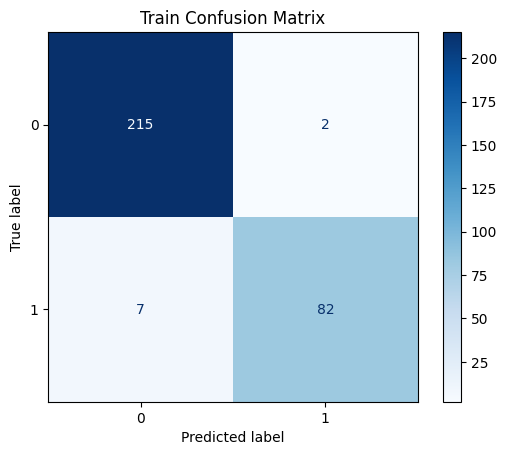

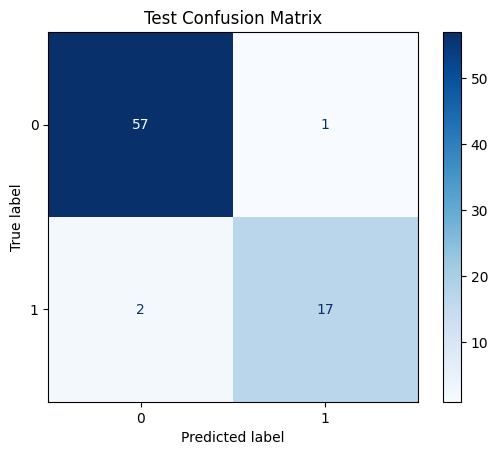

In [25]:
cm=confusion_matrix(train_y_scaled,train_y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_).plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

cm=confusion_matrix(test_y_scaled,test_y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_).plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()